In [ ]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [151]:
books = []
for i in range(5):
    books.append(pd.read_csv('drive/MyDrive/lab4/asoiaf-book{}-edges.csv'.format(i+1)))

In [152]:
all_books = pd.concat(books)

In [153]:
all_books

Source                        Target  \
0                     Addam-Marbrand               Jaime-Lannister   
1                     Addam-Marbrand               Tywin-Lannister   
2                  Aegon-I-Targaryen            Daenerys-Targaryen   
3                  Aegon-I-Targaryen                  Eddard-Stark   
4    Aemon-Targaryen-(Maester-Aemon)                Alliser-Thorne   
..                               ...                           ...   
755                 Tyrion-Lannister                        Ysilla   
756                  Tywin-Lannister                Wylis-Manderly   
757                Victarion-Greyjoy                         Wulfe   
758      Walder-Frey-(son-of-Jammos)  Walder-Frey-(son-of-Merrett)   
759                           Yandry                        Ysilla   

           Type  weight  book  
0    Undirected       3   1.0  
1    Undirected       6   1.0  
2    Undirected       5   1.0  
3    Undirected       4   1.0  
4    Undirected       4   1.0  
..          ...     ...   ...  
755  undirected      11   5.0  
756  undirected       3   5.0  
757  undirected       3   5.0  
758  undirected      10   5.0  
759  undirected      14   5.0  

[3909 rows x 5 columns]

In [154]:
edges = all_books.groupby(['Source','Target']).agg({'weight':'sum'}).reset_index()

In [155]:
edges.sort_values('weight',ascending=False)

Source              Target  weight
1334           Eddard-Stark    Robert-Baratheon     334
2031               Jon-Snow       Samwell-Tarly     228
1965      Joffrey-Baratheon         Sansa-Stark     222
1972      Joffrey-Baratheon    Tyrion-Lannister     219
640              Bran-Stark               Hodor     209
...                     ...                 ...     ...
1809        Jaime-Lannister            Joy-Hill       3
1805        Jaime-Lannister            Jon-Snow       3
1802          Jafer-Flowers       Jaremy-Rykker       3
1801  Jaehaerys-I-Targaryen  Maegor-I-Targaryen       3
0            Addam-Marbrand       Brynden-Tully       3

[2823 rows x 3 columns]

In [156]:
GOT = nx.from_pandas_edgelist(edges,
                            source='Source',
                            target='Target',
                            edge_attr='weight' )

In [157]:
num_nodes = GOT.number_of_nodes()
num_edges = GOT.number_of_edges()
average_degree = sum(dict(GOT.degree()).values()) / len(GOT.nodes())
info = {
    'Number of nodes': num_nodes,
    'Number of edges': num_edges,
    'Avareages degress': average_degree
}
print(info)

{'Number of nodes': 796, 'Number of edges': 2823, 'Avareages degress': 7.092964824120603}


In [158]:
weighted_degrees = dict(nx.degree(GOT,weight='weight'))
max_degree = max(weighted_degrees.values())

In [159]:
import seaborn as sns

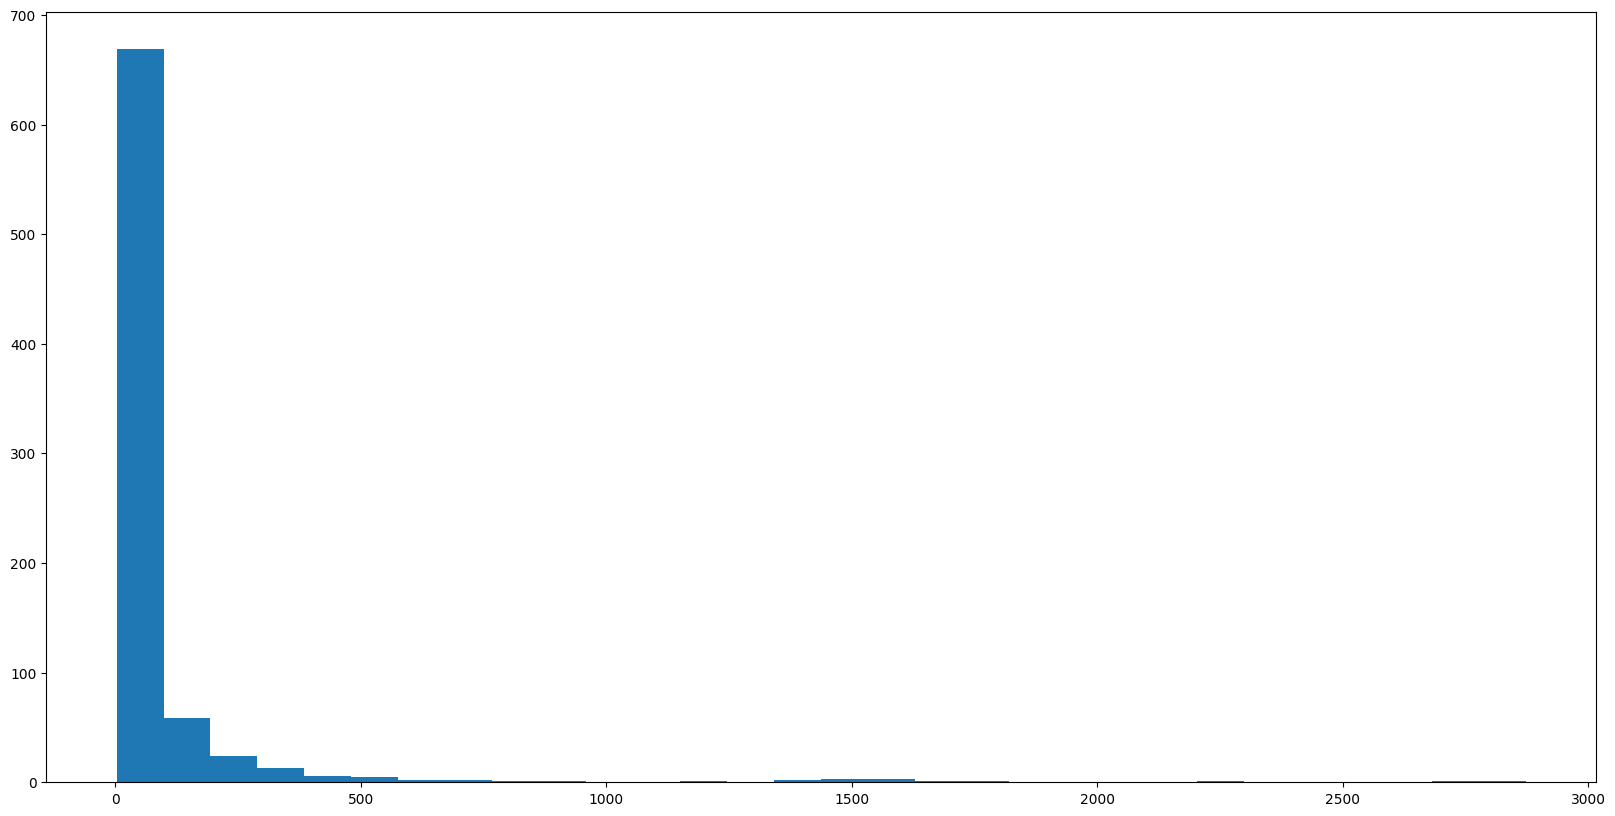

In [160]:
h = plt.hist(weighted_degrees.values(), bins = 30)

In [161]:
subG = GOT.subgraph([n for n in weighted_degrees if weighted_degrees[n]>200])

In [162]:
num_nodes = subG.number_of_nodes()
num_edges = subG.number_of_edges()
average_degree = sum(dict(subG.degree()).values()) / len(subG.nodes())
info = {
    'Number of nodes': num_nodes,
    'Number of edges': num_edges,
    'Avareages degress': average_degree
}
print(info)

{'Number of nodes': 63, 'Number of edges': 496, 'Avareages degress': 15.746031746031745}


In [163]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

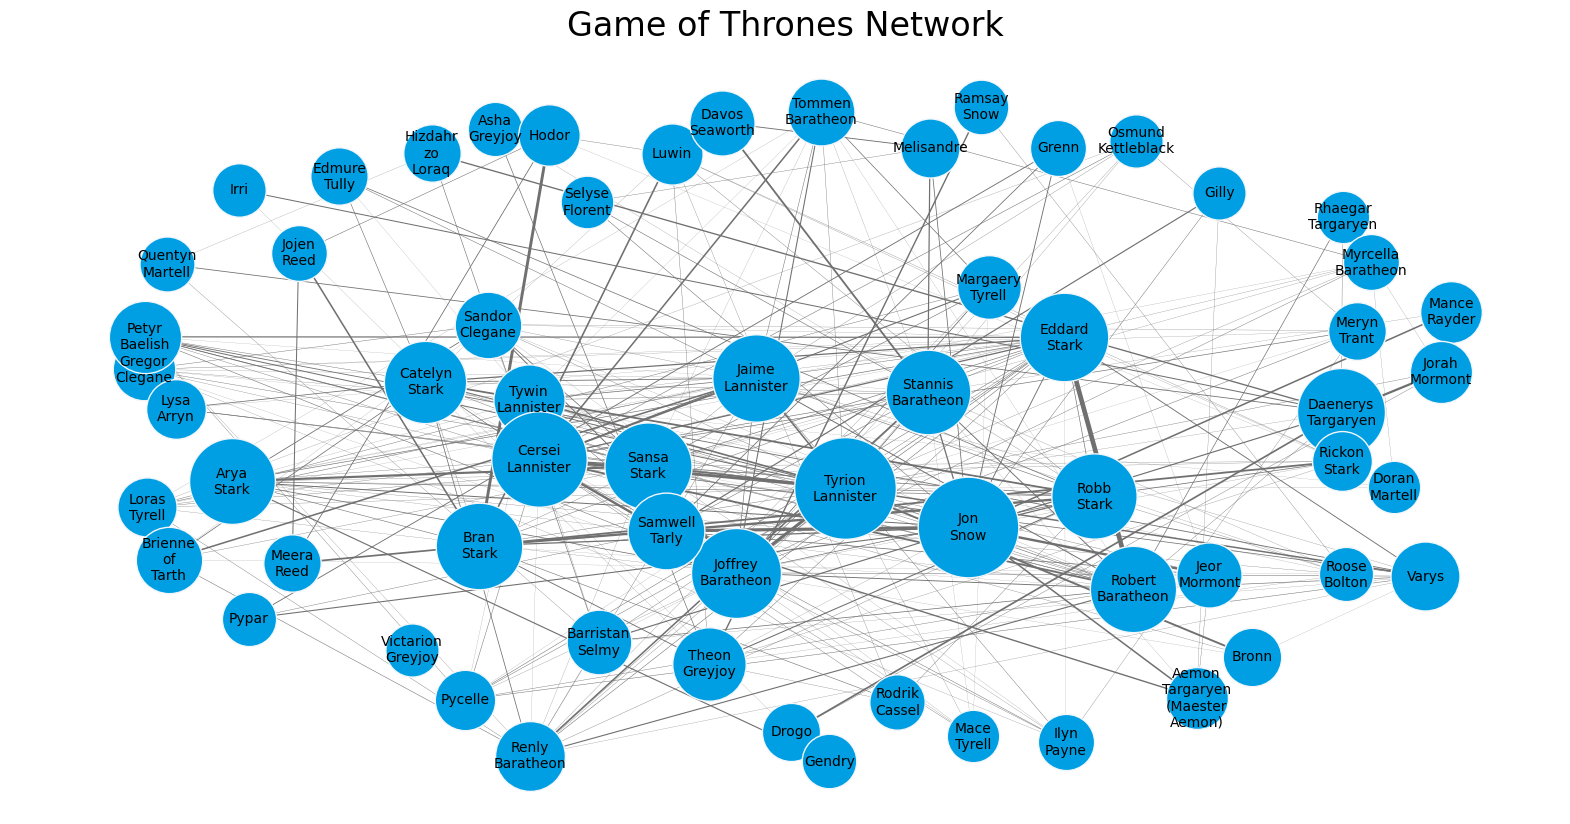

In [164]:
plt.axis('off')
plt.title('Game of Thrones Network',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>100},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

In [165]:
infection_times = {}

In [166]:
def linear_threshold(G, t, infection_times, thresholds):
    # Doing a t->t+1 step of linear_threshold simulation
    new_infections = []
    for n in G.nodes():
        if n not in infection_times:
            total_influence = sum(G[u][n]['weight'] for u in G.neighbors(n) if u in infection_times and infection_times[u] == t)
            if total_influence >= thresholds[n]:
                new_infections.append(n)

    for n in new_infections:
        infection_times[n] = t + 1

    return infection_times

In [167]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Game of Thrones Network, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#f2f6fa')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')


In [168]:

def initialize_thresholds(G):
    # Khởi tạo ngưỡng cho mỗi nút
    thresholds = {node: random.uniform(0, 500) for node in G.nodes()}
    return thresholds

In [169]:
infection_times = {'Bran-Stark':-1,'Samwell-Tarly':-1,'Jon-Snow':0}
import random
thresholds = initialize_thresholds(subG)  # Example thresholds

In [170]:
thresholds

{'Tyrion-Lannister': 439.46272315741135,
 'Osmund-Kettleblack': 237.9616587356761,
 'Quentyn-Martell': 82.02894955277662,
 'Bronn': 264.5037919959911,
 'Stannis-Baratheon': 349.1498921400572,
 'Asha-Greyjoy': 25.992327736696353,
 'Selyse-Florent': 50.89610259103233,
 'Robb-Stark': 294.6529172389139,
 'Arya-Stark': 134.92344063853545,
 'Mance-Rayder': 219.12202678796416,
 'Jon-Snow': 409.18481927110935,
 'Pypar': 398.72494299071445,
 'Rhaegar-Targaryen': 105.73702982435806,
 'Edmure-Tully': 290.4363592173375,
 'Eddard-Stark': 61.964931461787884,
 'Roose-Bolton': 64.16791135194988,
 'Drogo': 422.3460239524995,
 'Gilly': 139.0791909814215,
 'Grenn': 159.3043617062062,
 'Irri': 57.39730008335586,
 'Gregor-Clegane': 63.89783710509622,
 'Myrcella-Baratheon': 238.90514779657136,
 'Mace-Tyrell': 87.41697046030927,
 'Sandor-Clegane': 207.07307074800852,
 'Hodor': 293.9688570364114,
 'Barristan-Selmy': 102.8311784453872,
 'Margaery-Tyrell': 325.89755512854856,
 'Meera-Reed': 422.07143909801636,


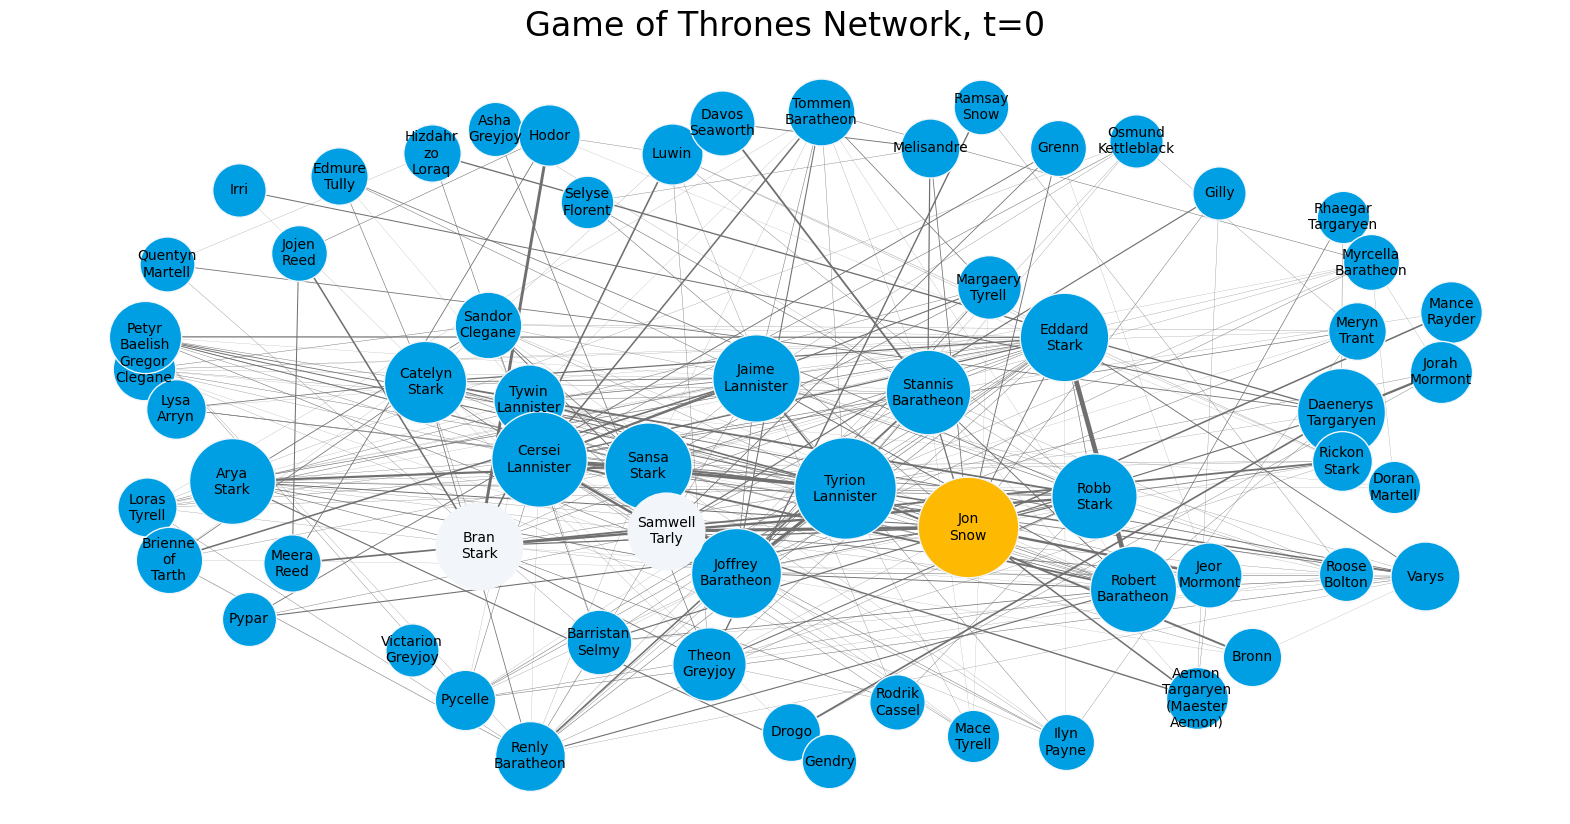

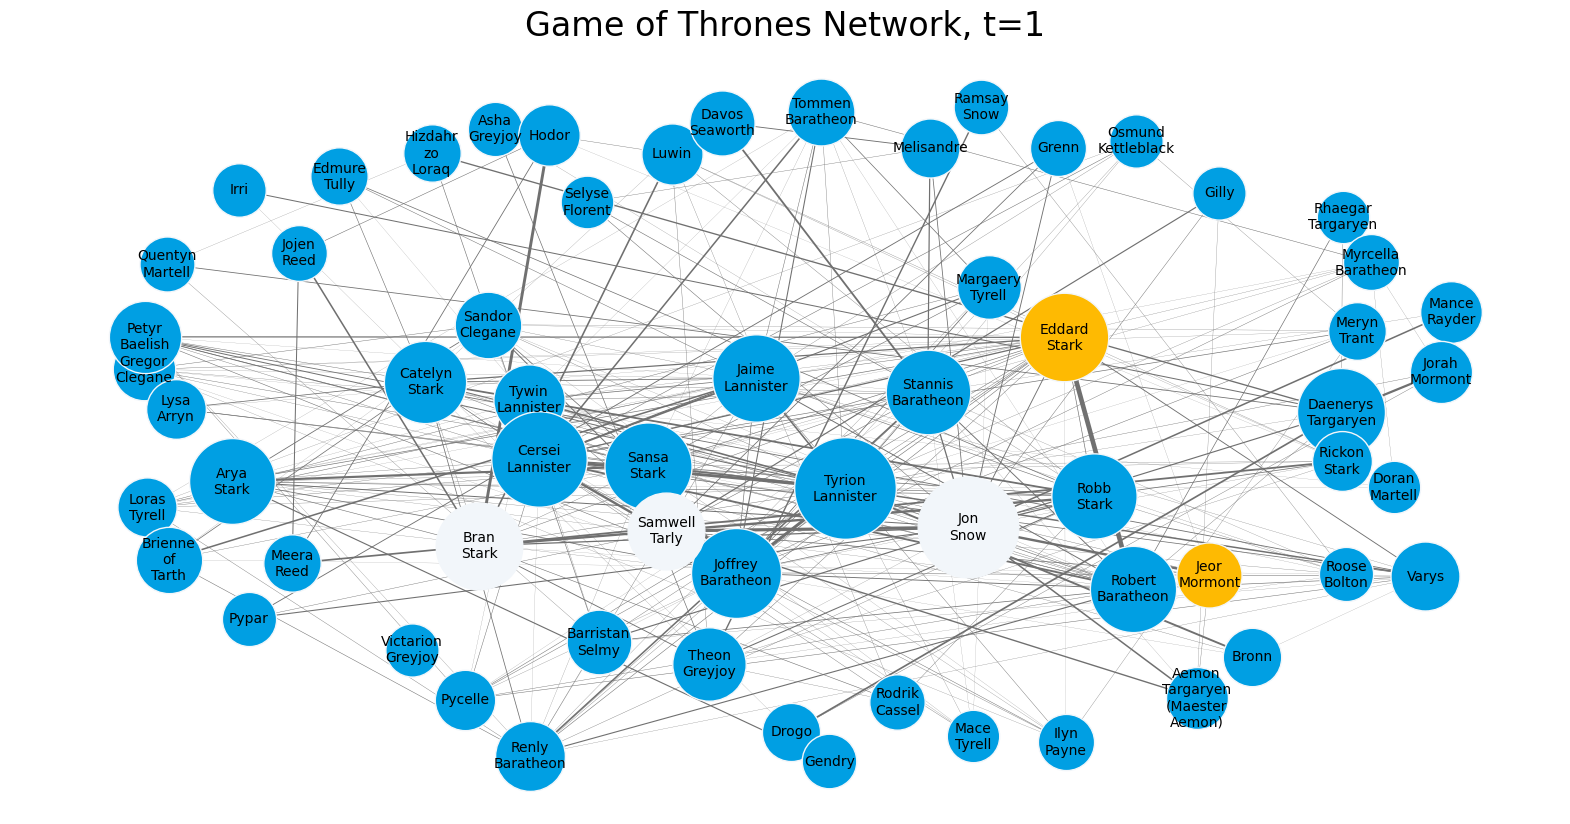

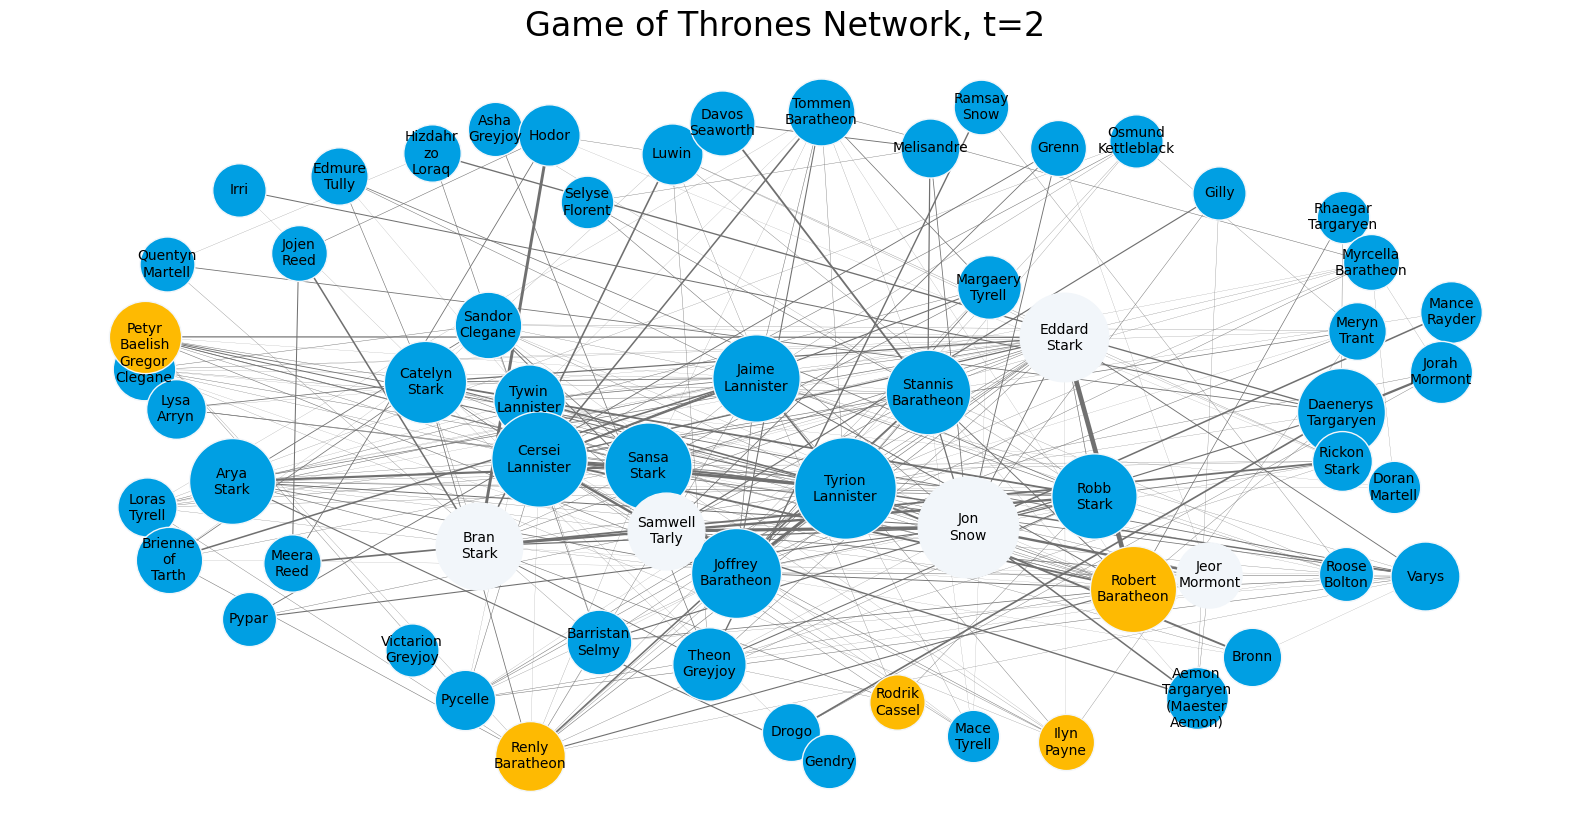

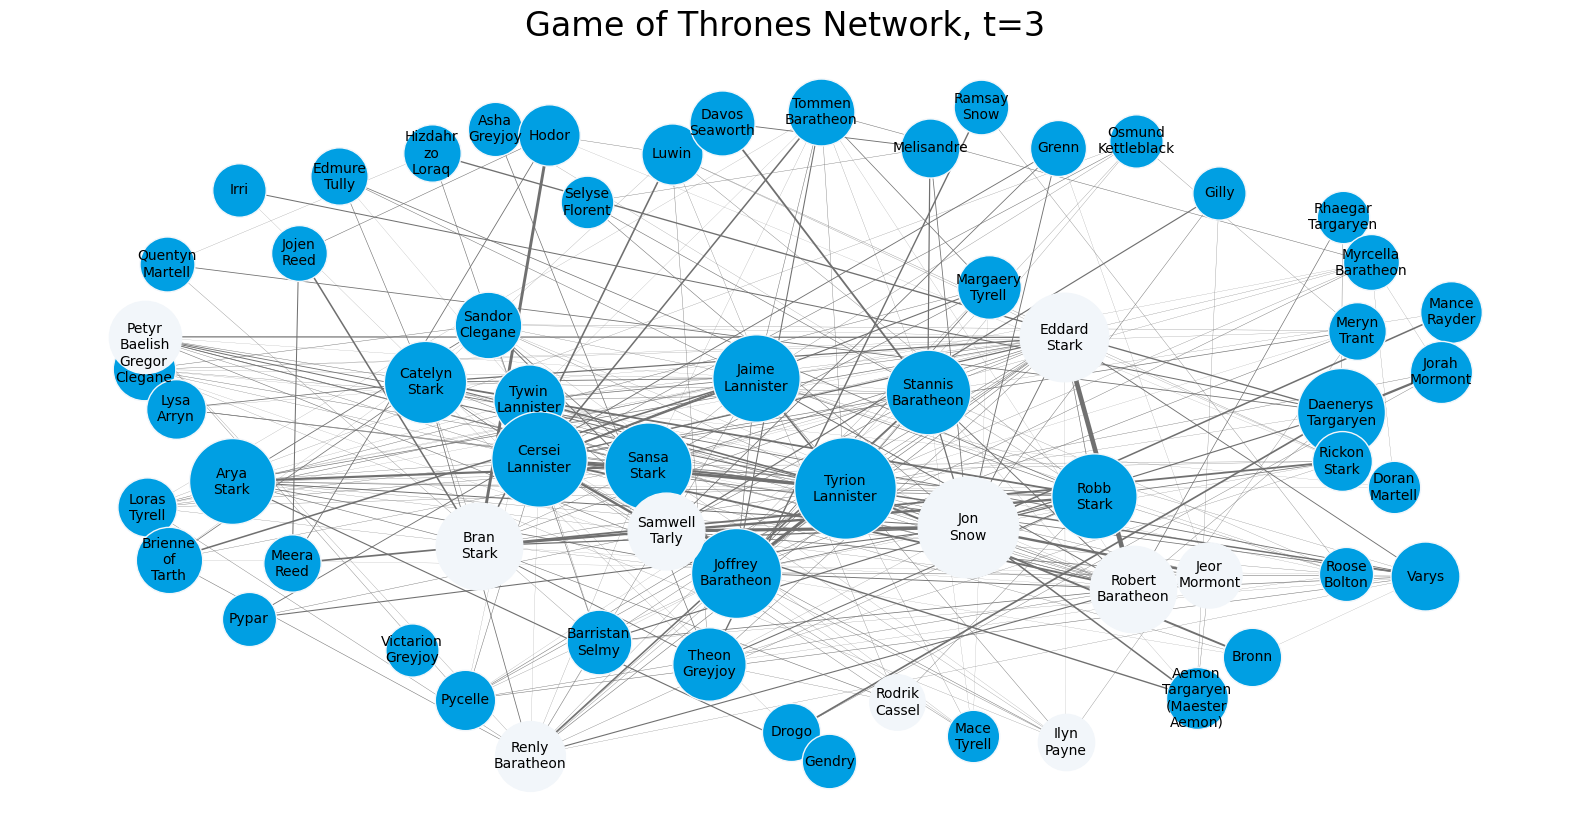

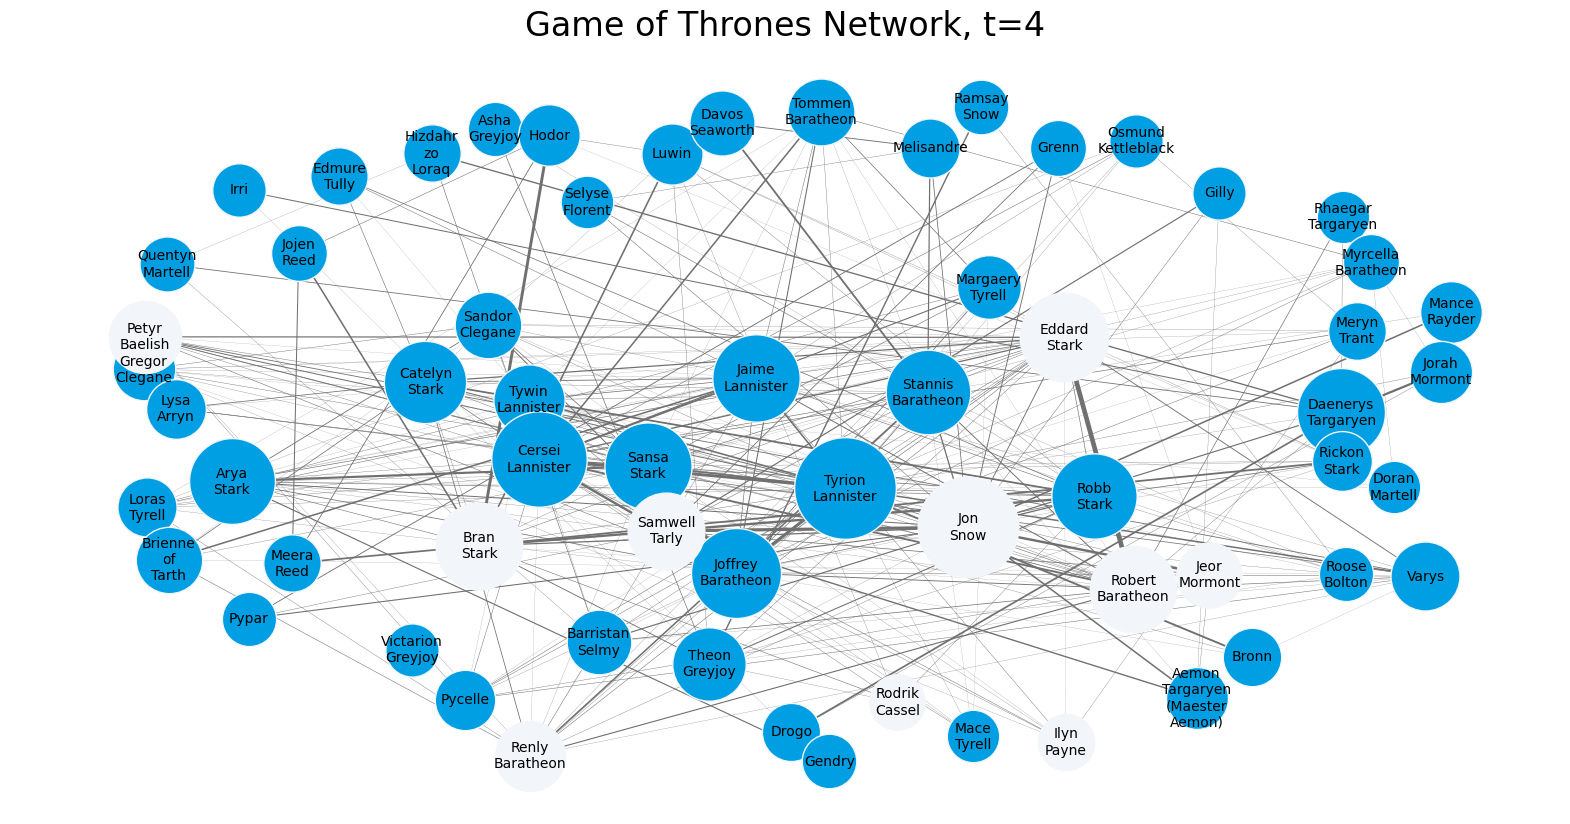

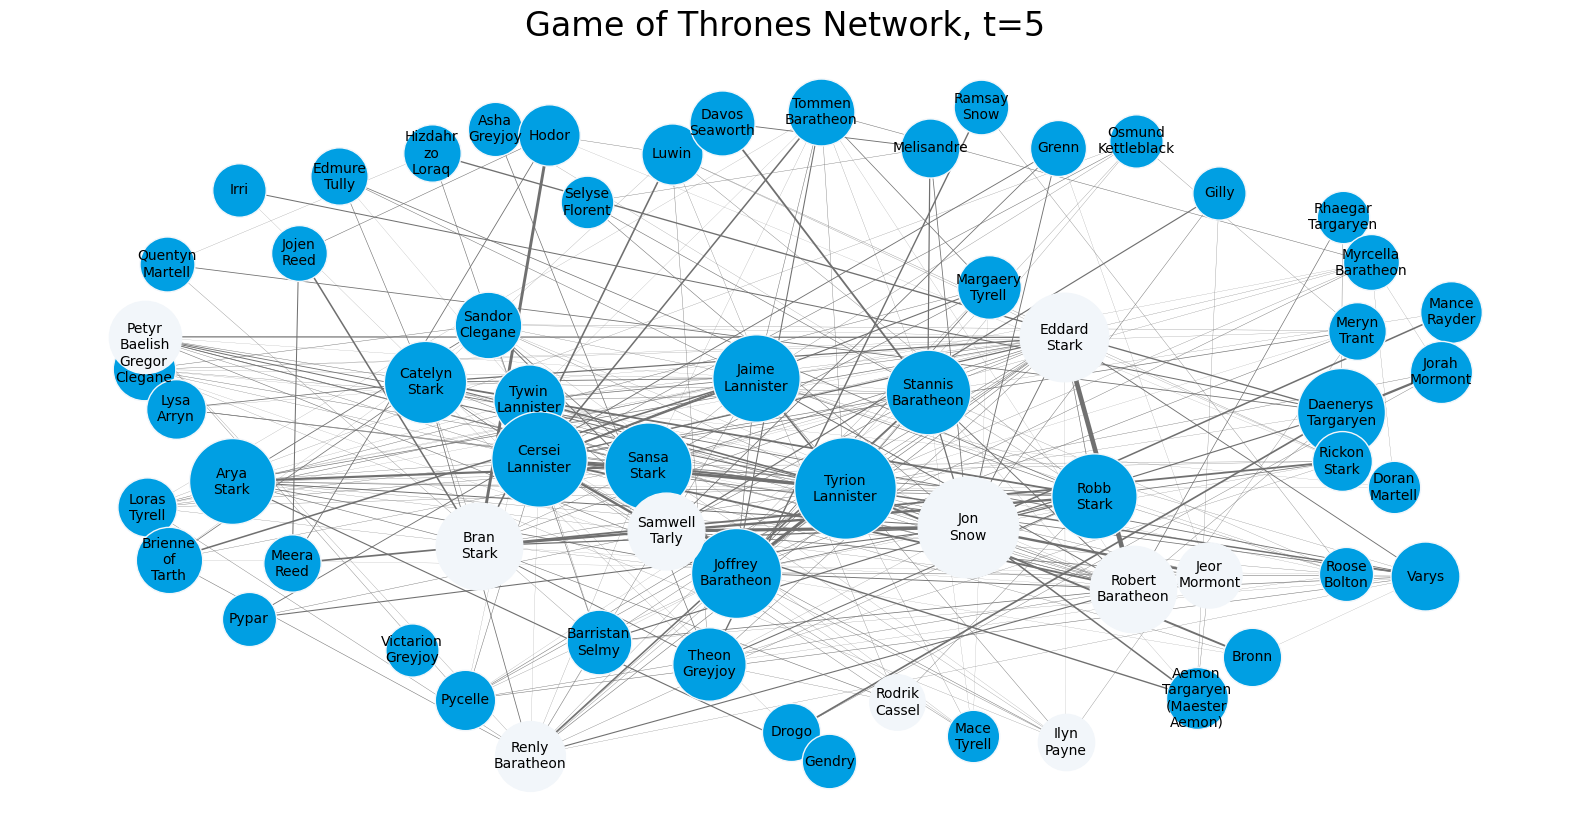

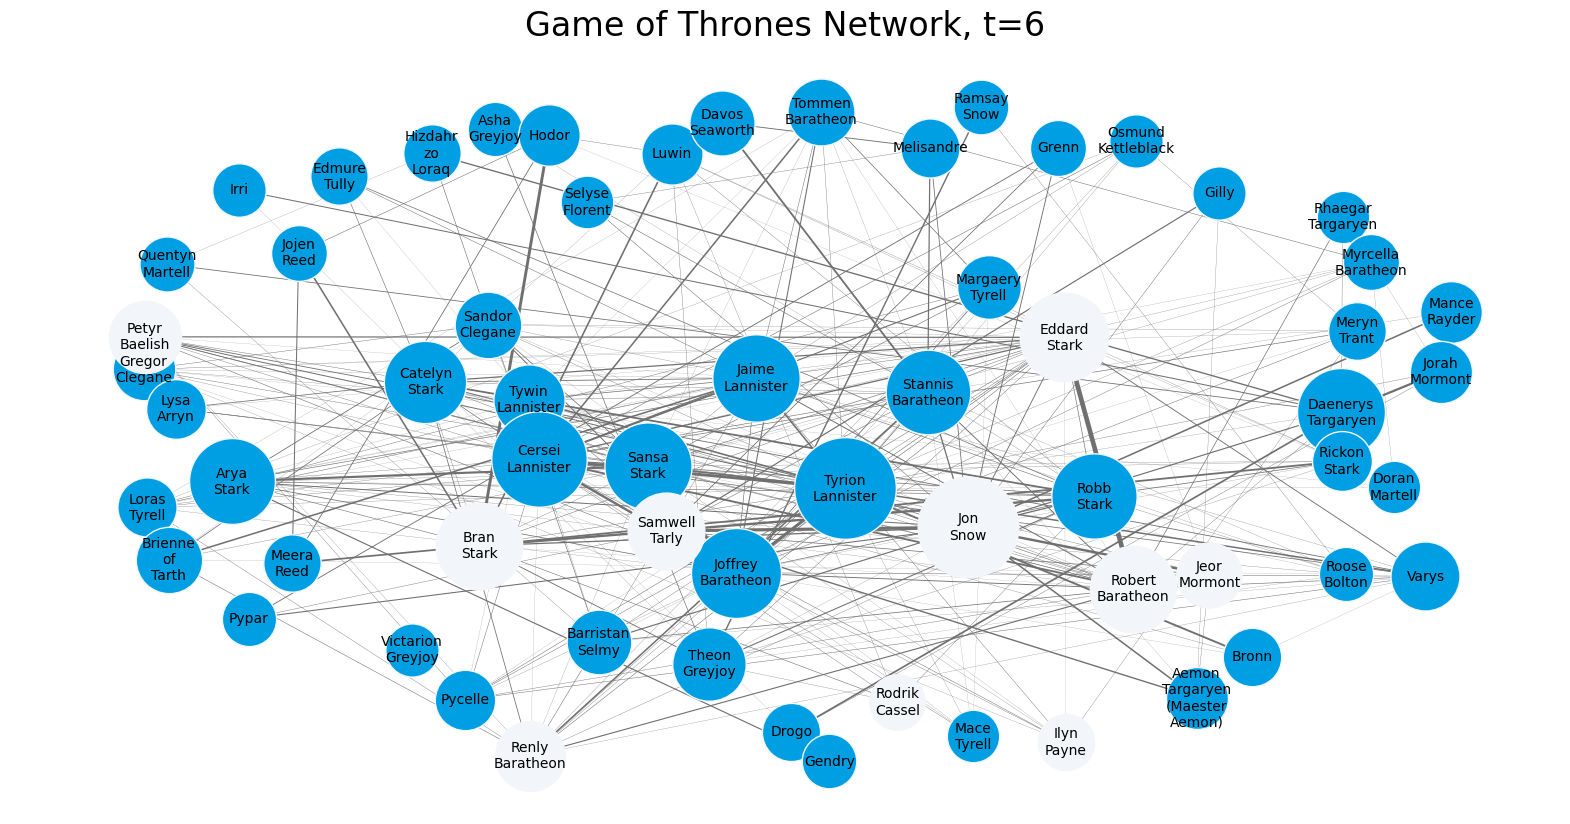

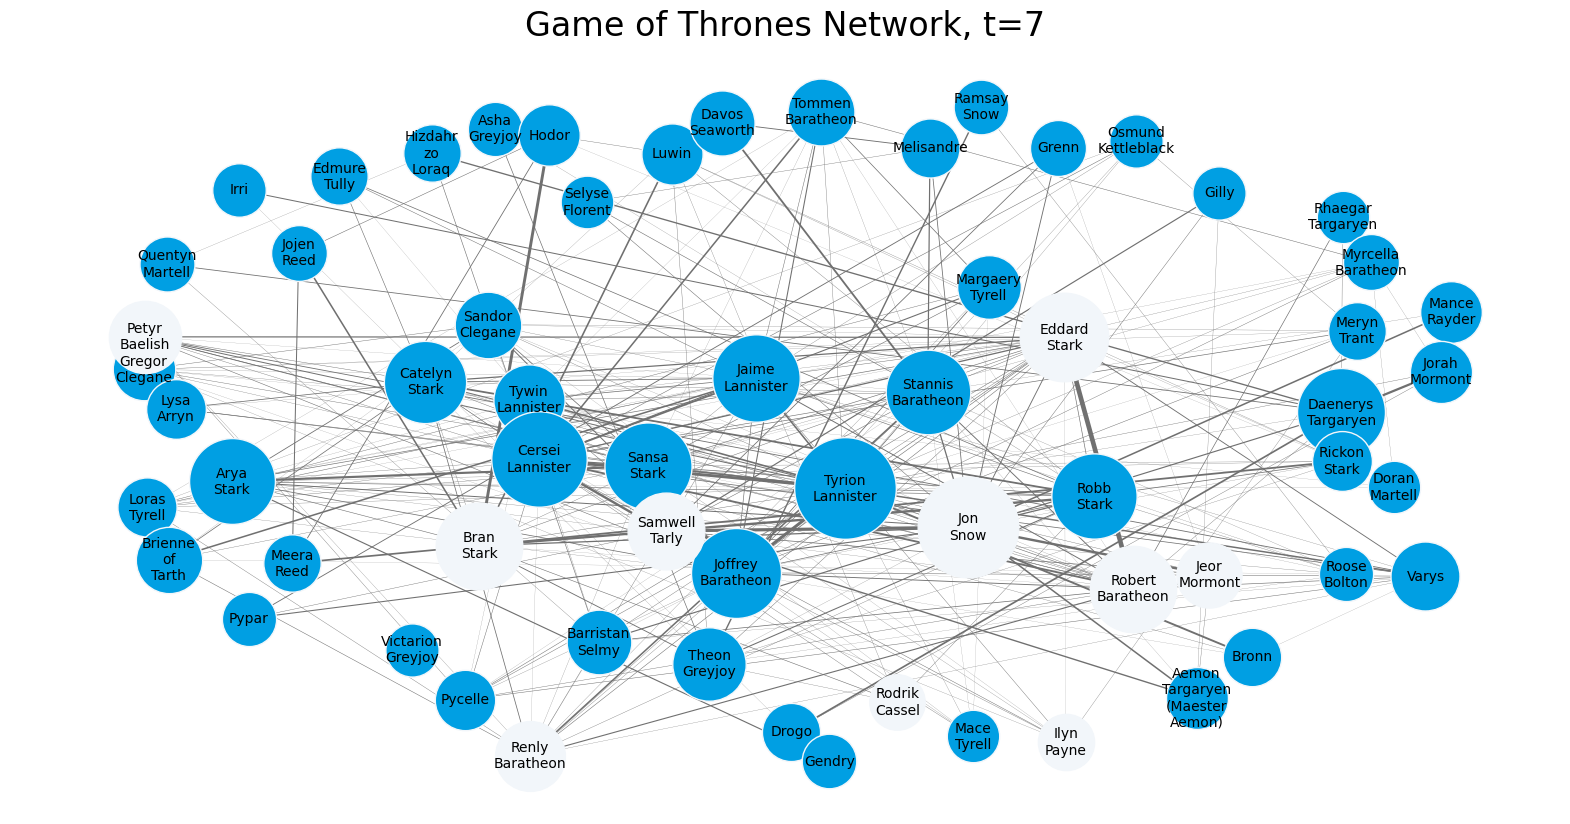

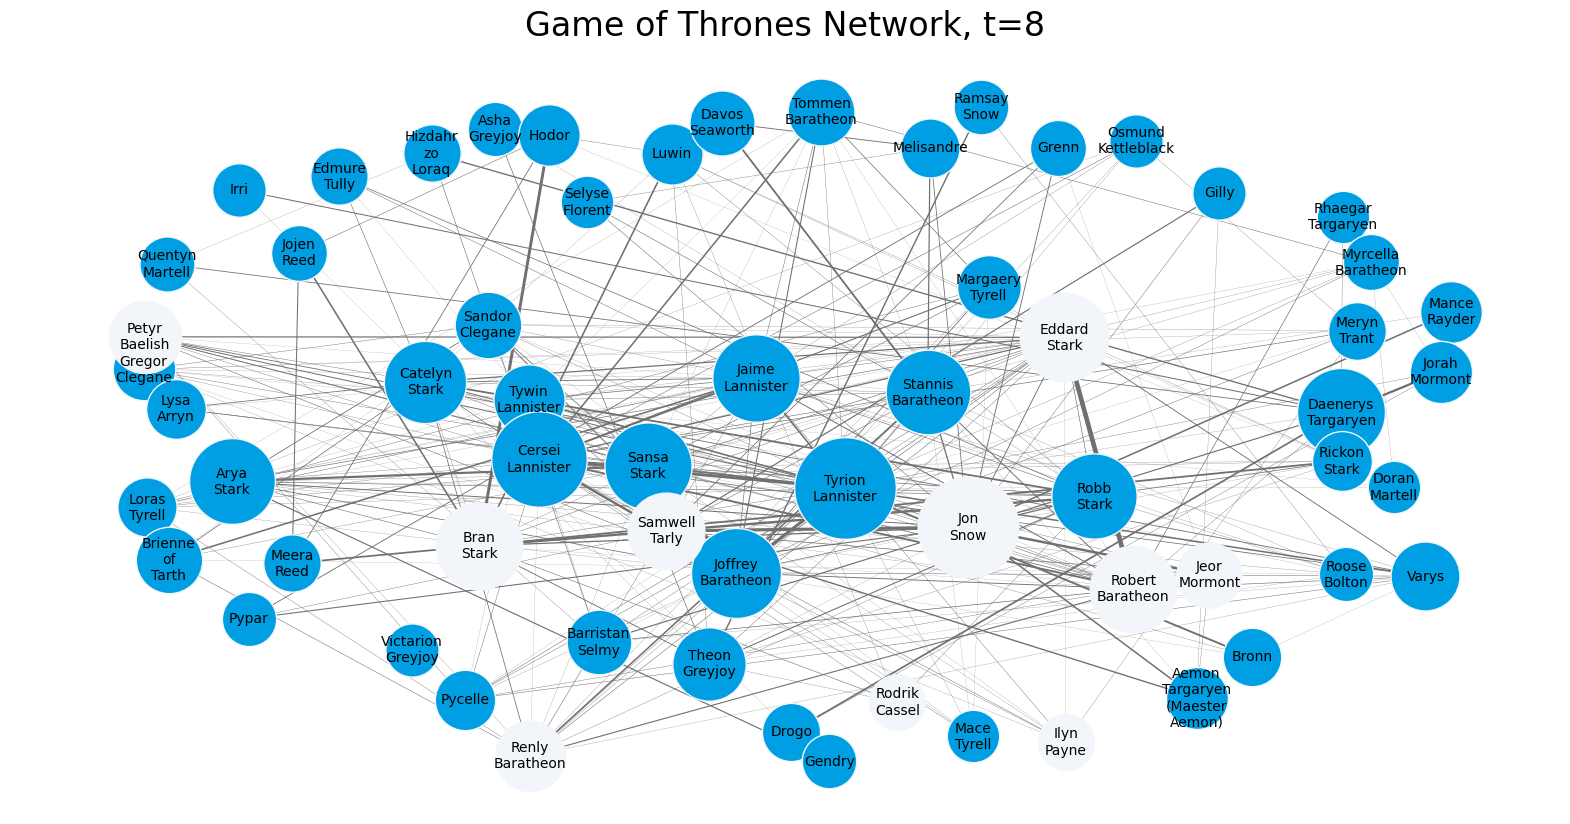

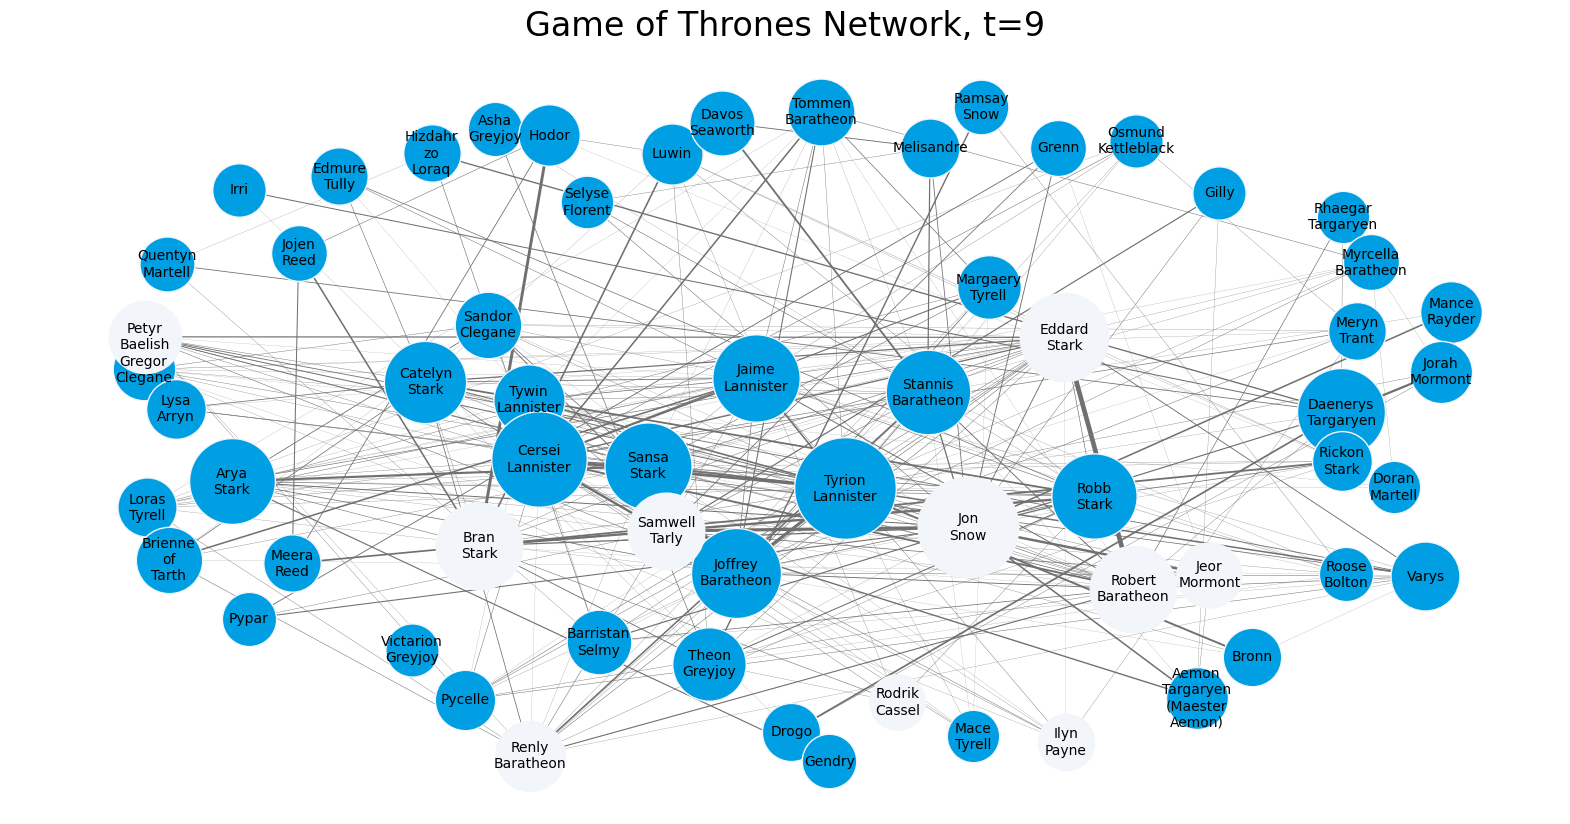

In [171]:
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = linear_threshold(subG, t, infection_times, thresholds)